In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

# Self driving car model analysis

The purpose of this analysis is try to explain the train and test proceses. Analysing data and augmentation this to improve accurary and later simulation over udacity simulator.

Without further ado, let's start with the step-by-step process:

**Step 1**: Let's import required classes & functions:

In [14]:
import os
from IPython.display import Image

from lib.config import Config
from lib.dataset_loader import DatasetLoader

from keras import backend as K

**Step 2**: Frist of all check that has a GPU available. This is required to decrease learning training times: 

In [15]:
print("Available GPU's: ", K.tensorflow_backend._get_available_gpus())

Available GPU's:  ['/job:localhost/replica:0/task:0/device:GPU:0']


**Step 3**: Load config file.

In [16]:
cfg = Config('./config.yml')

**Step 4**: Load dataset.

In [17]:
loader = DatasetLoader(cfg)

dataset = loader.load(
    features=cfg['dataset']['features'],
    labels=cfg['dataset']['labels']
)

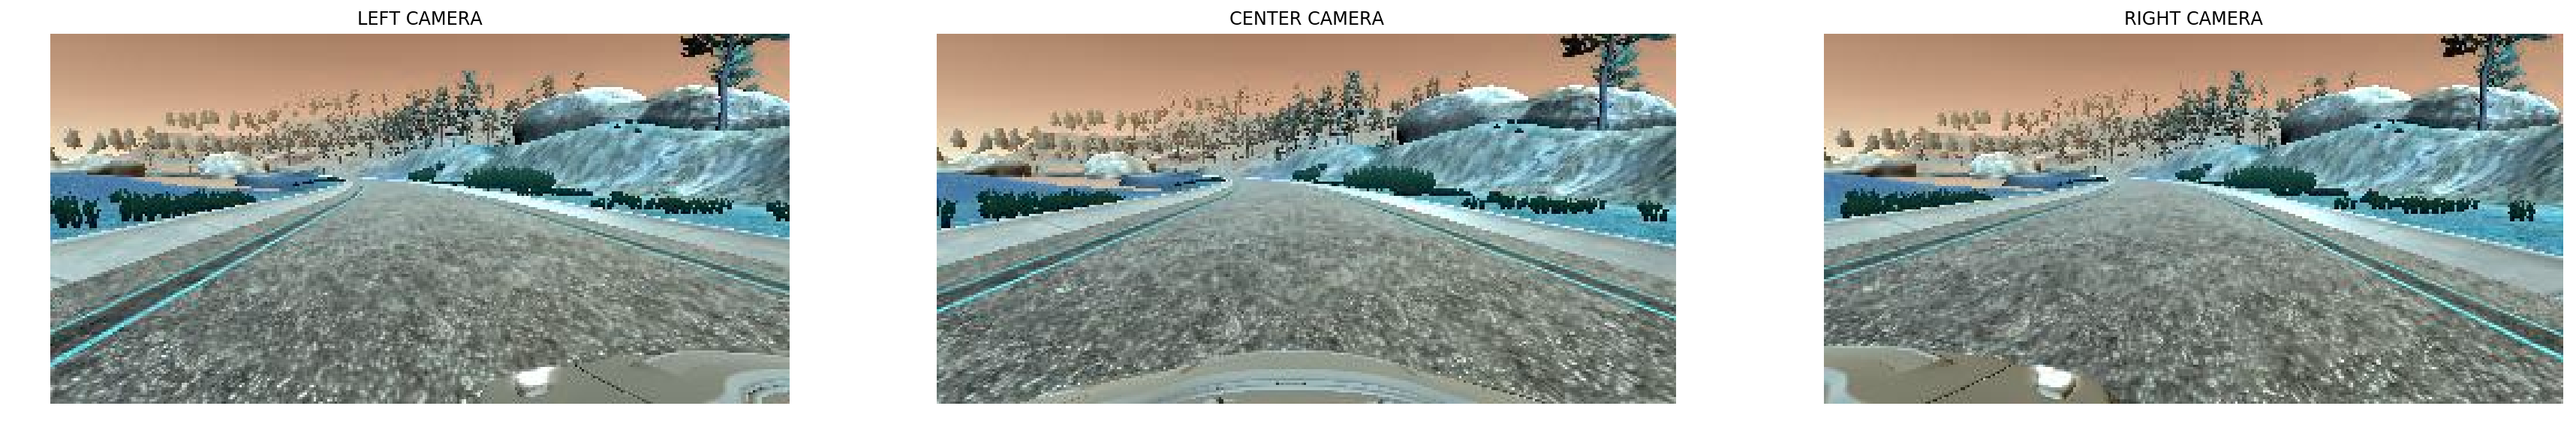

Steering Angle:  0.0


In [18]:
example = dataset[0]
example.show()

**Step 5**: Split dataset in train and validation.

In [19]:
train_dataset, validation_dataset = dataset.split(percent=cfg['train']['validation_set_size'])

In [20]:
print("Train dataset examples: ", len(train_dataset))

Train dataset examples:  651


In [21]:
print("Validation dataset examples: ", len(validation_dataset))

Validation dataset examples:  163
